In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


166

In [ ]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [ ]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
skip = 128

for person in range(1,33):
  print('Person No.' + str(person))

  # EEG files address

  address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']

  # Assigning classes
  label[label<5] = 0
  label[label>=5] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(40):
    sig = eeg[i][:32, :]
    sig = baseline_remove(sig)
    # Segmenting into 3 seconds (384 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += skip
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,32,256,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.1
Person No.2
Person No.3
Person No.4
Person No.5
Person No.6
Person No.7
Person No.8
Person No.9
Person No.10
Person No.11
Person No.12
Person No.13
Person No.14
Person No.15
Person No.16
Person No.17
Person No.18
Person No.19
Person No.20
Person No.21
Person No.22
Person No.23
Person No.24
Person No.25
Person No.26
Person No.27
Person No.28
Person No.29
Person No.30
Person No.31
Person No.32
(75520, 32, 256, 1)
(75520,) (32804,) (42716,)
(75520,) (31034,) (44486,)


30

# **Proposed Architecture**

In [ ]:
def CNN_LSTM_Self_Attention(x):
  x = Conv2D(filters = 40, kernel_size = (32, 45), strides = (1, 1), padding = 'valid', name = 'Conv2D_1')(x)
  x = BatchNormalization(name='BatchNormalization_1')(x)
  x = Activation('selu', name = 'Activation_1')(x)
  x = MaxPool2D(pool_size=(1, 75), strides = 10, name='MaxPool2D_1')(x)
  x = Reshape((-1, x.shape[1]*x.shape[2]*x.shape[3]), name='Reshape_1')(x)
  x = LSTM(64, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None,
           dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True, go_backwards=True, name='LSTM_1')(x)
  x = LSTM(64, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None,
           dropout=0.2, recurrent_dropout=0.2, return_sequences=True, go_backwards=True, name='LSTM_2')(x)
  y = MultiHeadAttention(num_heads=8, key_dim=8, name = 'MultiHeadAttention_1')(x, x)
  y = Activation('softmax', name = 'Activation_2')(y)
  x = Multiply(name='Multiply_2')([x, y])
  x = Flatten(name='Flatten_2')(x)
  x = Dense(2, activation='softmax', name='Dense_3') (x)
  return x


In [ ]:
def get_model() :
  input_shape = (data.shape[1], data.shape[2],1)
  a = Input(input_shape, name='Input')
  #out = channel_wise_attention(a)
  out = CNN_LSTM_Self_Attention(a)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=1e-4)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model
model = get_model()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 32, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv2D_1 (Conv2D)              (None, 1, 212, 40)   57640       ['Input[0][0]']                  
                                                                                                  
 BatchNormalization_1 (BatchNor  (None, 1, 212, 40)  160         ['Conv2D_1[0][0]']               
 malization)                                                                                      
                                                                                              

In [ ]:
batch_size = 128
epochs = 200
kfold = KFold(n_splits=5, random_state=1, shuffle=True)
gc.collect()

577

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(60416, 32, 256, 1) (15104, 32, 256, 1) (60416, 2) (15104, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}

foldNum=0
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model = get_model()
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  val_res['f1_score'].append(f1_score(y_test.argmax(1), pred.argmax(1), average='macro'))
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val
  gc.collect()

Results for fold 1
Epoch 1/200
378/378 [==============================] - 28s 28ms/step - loss: 0.7747 - accuracy: 0.5648 - val_loss: 0.7337 - val_accuracy: 0.5666
Epoch 2/200
378/378 [==============================] - 9s 24ms/step - loss: 0.7101 - accuracy: 0.6070 - val_loss: 0.6905 - val_accuracy: 0.6358
Epoch 3/200
378/378 [==============================] - 9s 24ms/step - loss: 0.6699 - accuracy: 0.6671 - val_loss: 0.6536 - val_accuracy: 0.6798
Epoch 4/200
378/378 [==============================] - 9s 24ms/step - loss: 0.6362 - accuracy: 0.6995 - val_loss: 0.6225 - val_accuracy: 0.7176
Epoch 5/200
378/378 [==============================] - 9s 24ms/step - loss: 0.6152 - accuracy: 0.7203 - val_loss: 0.6093 - val_accuracy: 0.7241
Epoch 6/200
378/378 [==============================] - 9s 25ms/step - loss: 0.5953 - accuracy: 0.7372 - val_loss: 0.5910 - val_accuracy: 0.7391
Epoch 7/200
378/378 [==============================] - 9s 24ms/step - loss: 0.5755 - accuracy: 0.7553 - val_loss: 0.

Accuracy  : 0.8865201354026795
F1_Score  : 0.883829300161381


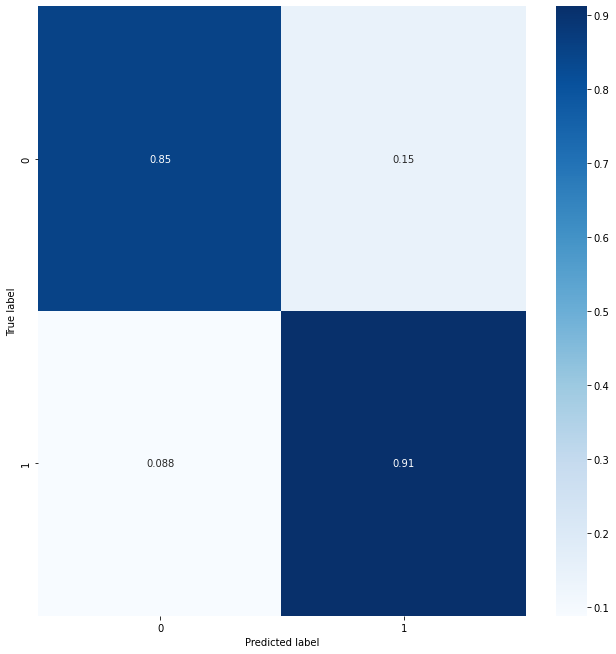

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(67968, 32, 256, 1) (7552, 32, 256, 1) (67968, 2) (7552, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/200
425/425 [==============================] - 30s 29ms/step - loss: 0.7539 - accuracy: 0.6063 - val_loss: 0.7021 - val_accuracy: 0.6566
Epoch 2/200
425/425 [==============================] - 12s 28ms/step - loss: 0.6749 - accuracy: 0.6721 - val_loss: 0.6465 - val_accuracy: 0.7004
Epoch 3/200
425/425 [==============================] - 11s 27ms/step - loss: 0.6336 - accuracy: 0.7034 - val_loss: 0.6167 - val_accuracy: 0.7174
Epoch 4/200
425/425 [==============================] - 11s 27ms/step - loss: 0.6075 - accuracy: 0.7222 - val_loss: 0.6030 - val_accuracy: 0.7288
Epoch 5/200
425/425 [==============================] - 11s 27ms/step - loss: 0.5870 - accuracy: 0.7393 - val_loss: 0.5725 - val_accuracy: 0.7516
Epoch 6/200
425/425 [==============================] - 11s 27ms/step - loss: 0.5675 - accuracy: 0.7536 - val_loss: 0.5572 - val_accuracy: 0.7656
Epoch 7/200
425/425 [==============================] - 12s 28ms/step - loss: 0.5522 - accuracy: 0.7639 - val_lo

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()